# Reinforcement Learning with Doom - Basic scenario

Leandro Kieliger
contact@lkieliger.ch

---
## Description

In this notebook we are going to set up our reinforcement learning environment with VizDoom and stable-baselines. This notebook has a corresponding [Medium article](https://lkieliger.medium.com/deep-reinforcement-learning-in-practice-by-playing-doom-part-1-getting-started-618c99075c77) which provides a high-level description.

The first scenario that we will try to solve is called "basic". In this scenario, the player is located in a square room, facing an ennemy. Only three actions are available: shoot, move left or move right. At the beginning of each episode, the ennemy will be located at a random location along the opposite wall of the room. The ennemy is immobile and passive. The goal of the scenario is to shoot the ennemy as fast as possible. For every time step we receive a reward of -1, missing a shot rewards -5 and successfully shooting the ennemy provides a reward of 101. The scenario can last at most 300 steps after which it is automatically restarted. 


# Code
## Preparations

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import vizdoom
from stable_baselines3 import ppo
from stable_baselines3.common import callbacks
from stable_baselines3.common import evaluation
from stable_baselines3.common import policies

To perform the learning task, we will need two components: the agent and the environment. Thanks to stable-baselines, building an agent will be very straightforward. The environment though requires some explanation. In the medium article we explain how to build the Gym environment wrapper for a VizDoom game instance.

In [2]:
from common import envs

def create_env(**kwargs) -> envs.DoomEnv:
    # Create a VizDoom instance.
    game = vizdoom.DoomGame()
    game.load_config('scenarios/basic.cfg')
    game.init()

    # Wrap the environment with the Gym adapter.
    return envs.DoomEnv(game, **kwargs)

There is one additional step required to make it work with stable-baselines. The good new is that this small additional step will unlock very cools features for the learning task.

What we need to set up is a vectorized environment. Stable-baselines' [doc](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vectransposeimage) has a nice explanation on what you can do with vectorized environments. Technically, we could do whithout but since we'll be exploring training on multiple environment later anyway, let's go ahead and see how to create one. In PyTorch, convolutional layers expect as inputs an image of the shape (C, H, W) that it, channels first. We could ask VizDoom to directly render the frame buffer in [channel-first](https://github.com/mwydmuch/ViZDoom/blob/master/doc/Types.md#-screenformat) mode. However, as we will see below, it is a better idea to keep the image channel last as this will allow us to make some image preprocessing using OpenCV. Thankfully, stable-baselines offers a [VecTransposeImage](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vectransposeimage) wrapper whose sole purpose is to convert from channel last to channel first and vice-versa. As you can see from the function signature, VecTransposeImage requires a VecEnv to work. So let's make one:

In [3]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage

def create_vec_env(**kwargs) -> VecTransposeImage:
    vec_env = DummyVecEnv([lambda: create_env(**kwargs)])
    return VecTransposeImage(vec_env)

So let's unpack what's going on here. First we have create a dummy vectorized environment. It need a list of function that when called, will generate our environment. Since there is only one element in this list we will end up with only one environment. Learning with multiple environment later will be as simple as adding more elements to that list. Then, we pass this dummy vectorized environment to the image transposition wrapper.

Although VizDoom provides many different screen resolutions. It is useful to define an additional frame processing step in which we rescale the input image by a given factor. This allows us the render the game in a nice resolution while keeping the input size to the model to an acceptable range. This can be easily done with a call to the resize function of OpenCV.

In [4]:
frame_processor = lambda frame: cv2.resize(frame, None, fx=.5, fy=.5, interpolation=cv2.INTER_AREA)

Doing so allow us to take advantage of OpenCV's interpolation to have a smoother image at the same resolution. A side-by-side comparison should make the advantage of rescaling the image ourselves pretty clear. Notice how aliased the image on the left is. This effect get worse and worse as the game tries to render furhter away (smaller) objects. If we can "see" better in the second image, so will our model!

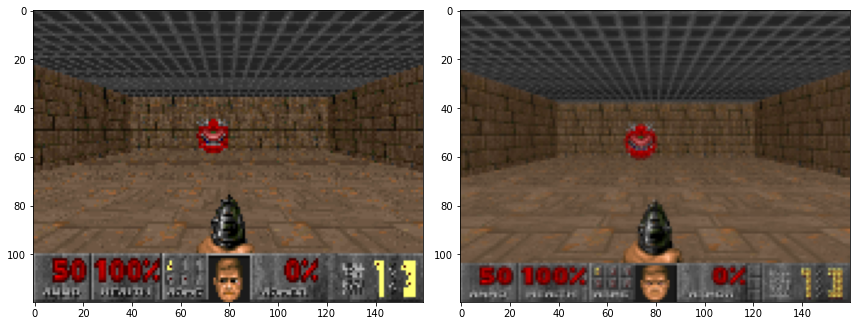

In [5]:
from basic import utils

f, ax = plt.subplots(1, 2, figsize=(12, 5))

# Compare 160 by 120 resolution vs. 320 by 240 resolution, scaled by half using OpenCV.
ax[0].imshow(utils.get_sample_frame(vizdoom.ScreenResolution.RES_160X120))
ax[1].imshow(frame_processor(utils.get_sample_frame(vizdoom.ScreenResolution.RES_320X240)))

plt.tight_layout()

## Creating the agent and the environment

We will create two environment, one for training and one for evaluatinng our agent. We will pass to both those environment a couple of parameters that are described below.

In [6]:
env_args = {
    # Number of steps for which the last action is repeated.
    'frame_skip': 4,
    # Scaling the input image allows us to see the game in good resolution while 
    'frame_processor': frame_processor
}

# Create training and evaluation environments.
training_env, eval_env = create_vec_env(**env_args), create_vec_env(**env_args)

As mentioned before, with stable baselines creating the agent is really straightforward. We can leave most of the parameters to their default values. By calling the PPO constructor we will get an agent with an actor-critic policy with the following structure in five parts:

```
       features extractor
               |
          mlp extractor
               |
            features
            /      \
           /        \
   action net      value net
```
If you want to know more about actor-critic methods, Rudy Gilman has an [awesome article](https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752) vulgarizing the subject by means of a comic.

By default, the feature extractor is the [NatureCNN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), the mlp extractor is empty and the action and value net are two sequential models mapping the features to the action and value output respectively.

In [7]:
def create_agent(env, **kwargs):
    return ppo.PPO(policy=policies.ActorCriticCnnPolicy,
                   env=env,
                   n_steps=4096,
                   batch_size=32,
                   learning_rate=1e-4,
                   tensorboard_log='logs/tensorboard',
                   verbose=0,
                   seed=0,
                   **kwargs)

agent = create_agent(training_env)
agent.policy

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=11264, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential()
    (value_net): Sequential()
  )
  (action_net): Linear(in_features=512, out_features=3, bias=True)
  (value_net): Linear(in_features=512, out_features=1, bias=True)
)

And with that we have everything we need to start the learning task! Within a couple of iterations you should see some progress in the behavior of the agent. Our model stabilizes at a total reward of around 85 which. The maximum score being 100, it means the model takes on average less than four steps to succeed (remember, we are repeated each action four actions due to the `frame_skip` parameter), that's awesome. Give yourself a tap on the back!

In [8]:
# Define an evaluation callback that will save the model when a new reward record is reached.
evaluation_callback = callbacks.EvalCallback(eval_env,
                                             n_eval_episodes=10,
                                             eval_freq=5000,
                                             log_path='logs/evaluations/basic',
                                             best_model_save_path='logs/models/basic')

# Play!
agent.learn(total_timesteps=40000, tb_log_name='ppo_basic', callback=evaluation_callback)

training_env.close()
eval_env.close()

Eval num_timesteps=5000, episode_reward=13.60 +/- 156.96
Episode length: 17.20 +/- 28.95
New best mean reward!
Eval num_timesteps=10000, episode_reward=36.40 +/- 149.41
Episode length: 10.90 +/- 21.52
New best mean reward!
Eval num_timesteps=15000, episode_reward=87.40 +/- 11.66
Episode length: 3.90 +/- 2.91
New best mean reward!
Eval num_timesteps=20000, episode_reward=83.50 +/- 10.80
Episode length: 4.70 +/- 2.49
Eval num_timesteps=25000, episode_reward=91.40 +/- 7.68
Episode length: 2.90 +/- 1.92
New best mean reward!
Eval num_timesteps=30000, episode_reward=87.40 +/- 10.35
Episode length: 3.90 +/- 2.59
Eval num_timesteps=35000, episode_reward=88.60 +/- 7.20
Episode length: 3.60 +/- 1.80
Eval num_timesteps=40000, episode_reward=79.40 +/- 9.02
Episode length: 5.90 +/- 2.26


## Saving the trained agent as a gif

Now that we have an agent able to align and shoot enemies, let's make a little souvenir and save it's performance in the form of an animated gif.

In [9]:
import imageio

def make_gif(agent, file_path):
    env = create_vec_env(frame_skip=1, frame_processor=frame_processor)
    env.venv.envs[0].game.set_seed(0)
    
    images = []

    for i in range(20):
        obs = env.reset()

        done = False
        while not done:
            action, _ = agent.predict(obs)
            obs, reward, done, _ = env.step(action)
            images.append(env.venv.envs[0].game.get_state().screen_buffer)

    imageio.mimsave(file_path, images, fps=35)

    env.close()

In [10]:
# Uncomment this if you want to pick the best model from a previous training session
# agent = ppo.PPO.load('logs/models/basic/best_model.zip')
make_gif(agent, 'figures/basic_agent.gif')

You might notice that the agent has the tendency to shoot too early in the gif. This is because to create a smooth-looking gif we had to create an environment where the frame skip is set to 1. We can fix this very easily by taking our trained agent and learning a few more steps but this time with the final environment.

In [11]:
env = create_vec_env(frame_skip=1, frame_processor=frame_processor)

agent.set_env(env)
agent.learn(total_timesteps=20000)

env.close()
make_gif(agent, 'figures/basic_agent_adjusted.gif')

![Comparison frame skip](figures/basic_agent_adjusted.gif)

# Part 2 - Improvements

## Comparing the effects of the frame skip parameter

Reinforcement learning models are notoriously hard to train. Often, a lot of care must be put into finding the correct hyperparameters for the model: learning rate, clip range, epochs per update etc. I found the frame skip setting to be one of the most influencial parameters on the learning performance. My intuitive explanation is that a larger frame skip allow the model to explore more rapidly the environment and thus encounter positive situation more often. Indeed if you try setting it to one for example, you will find that for many episodes where the monster is spawned near the border walls, the agent makes random action that tend to stay within the center of the room. This behaviour means that he is much less likely to shoot the ennemy by luck and there much less likely to receive positive rewards.

I conducted a series of experiments with varying frame skip sizes, running 6 consecutive learning and averaged the results. Each error bar denotes the error mean: $ \frac{\sigma}{\sqrt{n}}$.

![Comparison frame skip](figures/basic_comparison_frame_skip.png)

The second most influencial parameter on the learning performance is the learning rate. In most of the VizDoom examples, I found the maximum possible learning rate to be between 1e-3 and 1-4. Empirically, a learning rate that is too high seems to quickly push the agent in a state where it always outputs the same actions whereas a learning rate that is too low makes the learning procedure needlessly long.

## Simplifying the model

You might have realized that using 160 by 120 pixels input image for this scenario is completely unnecessary. The roof and the floors do not add any meaningful information to our model, only the middle of the frame posesses information. Cutting the meaningless parts means that our model will need significantly less trainable parameters. At the moment, the number of parameters is:  

In [12]:
def count_trainable_parameters(model):
    print('Number of trainable parameters: {:,}'.format(
    sum(p.numel() for p in model.policy.parameters() if p.requires_grad)))

In [13]:
count_trainable_parameters(agent)

Number of trainable parameters: 5,845,668


If we modify our environment and use instead a cropped version of the input frame, we can reduce the number of parameters by 2.6M.

In [14]:
frame_processor = lambda frame: cv2.resize(frame[40:-41, :], None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
env = create_vec_env(frame_processor=frame_processor); agent = create_agent(env); env.close()
count_trainable_parameters(agent)

Number of trainable parameters: 3,224,228


In addition, the PPO class from stable-baselines allows us to directly modify the architecture of the model using keyword arguments. In particular, the default number of features produced at the end of the convolutional layers is 512. This is also unnecessarily large.

In [15]:
agent = create_agent(env, policy_kwargs={'features_extractor_kwargs': {'features_dim': 128}})
count_trainable_parameters(agent)

Number of trainable parameters: 863,012


And just like that, we decreased the size of trainable parameters by a factor 7. Let see how this new model compares to the old. Training this simplified model produces results on par with the more complex one while being faster to train.

In [16]:
env_args = {'frame_skip': 4, 'frame_processor': frame_processor}

training_env, eval_env = create_vec_env(**env_args), create_vec_env(**env_args)
agent.set_env(training_env)

evaluation_callback = callbacks.EvalCallback(eval_env,
                                             n_eval_episodes=10,
                                             eval_freq=5000,
                                             log_path='logs/evaluations/basic',
                                             best_model_save_path='logs/models/basic')

agent.learn(total_timesteps=40000, tb_log_name='ppo_basic_simplified', callback=evaluation_callback)

training_env.close()
eval_env.close()

Eval num_timesteps=5000, episode_reward=-263.90 +/- 111.67
Episode length: 68.30 +/- 20.10
New best mean reward!
Eval num_timesteps=10000, episode_reward=-106.10 +/- 194.05
Episode length: 39.40 +/- 35.65
New best mean reward!
Eval num_timesteps=15000, episode_reward=88.60 +/- 9.16
Episode length: 3.60 +/- 2.29
New best mean reward!
Eval num_timesteps=20000, episode_reward=76.60 +/- 23.57
Episode length: 5.40 +/- 4.27
Eval num_timesteps=25000, episode_reward=83.80 +/- 11.29
Episode length: 4.80 +/- 2.82
Eval num_timesteps=30000, episode_reward=88.60 +/- 9.83
Episode length: 3.60 +/- 2.46
Eval num_timesteps=35000, episode_reward=89.10 +/- 9.02
Episode length: 3.30 +/- 2.05
New best mean reward!
Eval num_timesteps=40000, episode_reward=83.40 +/- 10.35
Episode length: 4.90 +/- 2.59


# Conclusion

In this notebook we've seen how to setup and adapt VizDoom to use it as reinforcement learning environment with the powerful stable-baselines library. In the next chapter we will explore a more complex scenario and dwelve into the model in more details. Stay tuned!